### First, brief intro: Functional margin ($\hat \gamma$) and geometric margin ($\gamma$)

$$ \text{Definition for the functional margin of data point  } x^{(i)}$$:

$$\hat \gamma^{(i)} = y^{(i)}(w^T x^{(i)} + b)$$

$$\text{Given    } y^{(i)} \text{  is   } \pm 1 \text{   for the positive and negative examples   }, \hat \gamma^{(i)} \text{    is actually equivalent to     } | w^T x^{(i)} + b |$$


$$ \text{  which is a scaled distance of x to the line (verified by geometry)  } w^T x^{(i)} + b = 0 \text{   and the scaler is     } \left\|w\right\|$$. 



$$ \text{  If we let   } x_0  \text{ be the vector that is perpendicular to the line, and also exactly on the line.}  $$

$$ \hat \gamma \text{ can also be written in terms of   } x_0$$


$$\begin{align*}
\hat \gamma^{(i)} &= y^{(i)}(w^T x^{(i)} + b)\\
            &= |w^T x^{(i)} + b| \\
            &= y^{(i)}w^T(x^{(i)} - x_0)
\end{align*}$$



$$ \text{ In the context of a training set with multiple data points  } x^{(1)}, x^{(2)}, \cdots, x^{(m)} \text{ , we define the functional margin of the training set (   } \hat \Gamma  \text{  ) to be  }$$ 

$$\hat \Gamma = \mathrm{min}_{i=i,\cdots,m} \hat \gamma^{(i)}$$



## SVM

 After some reasoning: the SVM becomes an optimization problem for the following optimal margin classifier:

     
$$\mathrm{min}_{\gamma, w, b} \frac{1}{2}\left\|w\right\|^2 $$
     
$$\text{ Subject to:   } y^{(i)}(w^Tx^{(i)} + b) \ge 1, i = 1, 2, \cdots, m$$



Applying Lagrange duality, the optimization problem becomes

![](../images/svm1.png)

![](../images/svm2.png)

![](../images/svm3.png)

![](../images/svm4.png)

![](../images/svm5.png)

![](../images/svm6.png)

> Then how do SVM complete a classification task?

After converting w, adjust the format of f(x):

![](../images/svm7.png)

__Thus when attempting to classify a new data point, just calculate the inner product of this point and training data points whose cluster belonged to is already known, then check the sign of f(x)__


$$
\mathrm{max}_{\alpha} W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m}y^{(i)}y^{(j)} \alpha_i \alpha_j x_i^T x_j
$$
Subject to:
$$0 \le \alpha_i \le C, i = 1, 2, \cdots, m$$
and
$$\sum_{i=1}^{m} \alpha_i y^{(i)} = 0$$


In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
# toy dataset
Xs = np.array([
        [0.5, 0.5],
        [1, 1],
        [1.5, 2],
        [2, 1]
    ])
ys = [-1, -1, 1, 1]

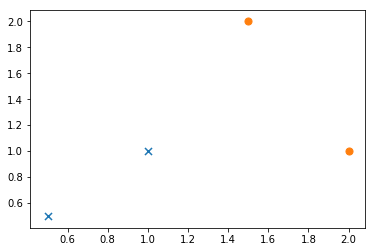

In [49]:
plt.scatter(*Xs[:2].T, marker='x', s=50)
plt.scatter(*Xs[2:].T, marker='o', s=50)

In [17]:
def calc_f(xk, alphas, Xs, ys, b):
    return sum(alpha * yi * xi.dot(xk) for (alpha, xi, yi) in zip(alphas, Xs, ys)) + b

In [18]:
def calc_E(xk, yk, alphas, Xs, ys, b):
    return calc_f(xk, alphas, Xs, ys, b) - yk

In [19]:
def calc_Lower(yi, yj, ai, aj, C):
    if yi != yj:
        return max(0, aj - ai)
    elif yi == yj:
        return max(0, ai + aj - C)
    else:
        raise
        
def calc_Upper(ai, aj, yi, yj, C):
    if yi != yj:
        return min(C, aj - ai + C)
    elif yi == yj:
        return min(C, ai + aj)
    else:
        raise

In [20]:
# determine a_j first
def update_a_j(aj, yj, Ei, Ej, eta, Upper, Lower):
    aj = aj - yj * (Ei - Ej) / eta
    if aj > Upper:
        return Upper
    elif aj < Lower:
        return Lower
    else:
        return aj

# then determine a_i based on a_j's pos
def update_a_i(ai, yi, yj, aj_old, aj):
    return ai + yi * yj * (aj_old - aj)

In [21]:
def calc_b(b1, b2, ai, aj, C):
    if 0 < ai < C:
        return b1
    elif 0 < aj < C:
        return b2
    else:
        return (b1 + b2) / 2

In [22]:
# the toy example is linearly separable, so C could be arbitrarily large
C = 1e8
tol = 0.001
max_iter = 10000

n = Xs.shape[0]
alphas = np.zeros(n)
b = 0

In [25]:
iter = 0
while iter < max_iter:
    num_changed_alphas = 0
    for i in range(n):
        # initialize alpha,x,y,err
        ai = alphas[i]
        xi = Xs[i]
        yi = ys[i]
        Ei = calc_E(xi, yi, alphas, Xs, ys, b)
        if (yi * Ei < -tol and ai < C) or (yi * Ei > tol and ai > 0):
            j = np.random.choice([_ for _ in range(m) if _ != i])
            aj = alphas[j]
            xj = Xs[j]
            yj = ys[j]
            Ej = calc_E(xj, yj, alphas, Xs, ys, b)
            
            # preserve the previous position of a_i and a_j
            ai_old = ai
            aj_old = aj
            
            Lower = calc_Lower(ai, aj, yi, yj, C)
            Upper = calc_Upper(ai, aj, yi, yj, C)
            if Lower == Upper:
                continue
                
            eta = 2 * xi.dot(xj) - xi.dot(xi) - xj.dot(xj)
            if eta >= 0:
                continue
                
            aj = update_a_j(aj, yj, Ei, Ej, eta, Upper, Lower)
            alphas[j] = aj
            if np.abs(aj - aj_old) < 1e-5:
                continue
            
            ai = update_a_i(ai, yi, yj, aj_old, aj)
            
            alphas[i] = ai
            
            
            b1 = b - Ei - yi * (ai - ai_old) * xi.dot(xi) - yj * (aj - aj_old) * xi.dot(xj)
           
            b2 = b - Ej - yi * (ai - ai_old) * xi.dot(xj) - yj * (aj - aj_old) * xj.dot(xj)
            
            b = calc_b(b1, b2, ai, aj, C)
            num_changed_alphas += 1
            
    if num_changed_alphas == 0:
        iter += 1
    else:
        iter = 0

In [28]:
alphas

array([ 0.        ,  2.50031104,  1.00062208,  1.49968896])

In [29]:
b

-4.0006220800000012

In [32]:
# most alphas should be 0
ws = sum([alphas[i] * ys[i] * Xs[i] for i in range(m)])

In [35]:
norm_ws = ws / np.sqrt(ws.dot(ws))
(norm_ws**2).sum() # should be converging to 1 as much as possible

0.99999999999999989

In [36]:
margin = np.min(np.abs(Xs.dot(ws) + b) / np.sqrt(ws.dot(ws))) # the min distance of point xs to y=wx+b

(0, 2.2)

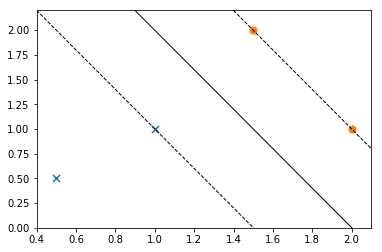

In [17]:

_x1s = np.array([0, 3])
_x2s = (-b - ws[0] * _x1s) / ws[1]


_xs = np.array([_x1s, _x2s]).T
assert (_xs[1] - _xs[0]).dot(ws) < 1e-12

# decision boundary
plt.plot(*_xs.T, lw=1, color='black')
# margin
plt.plot(*(_xs - norm_ws * margin).T, color='black', lw=1, linestyle='--')
plt.plot(*(_xs + norm_ws * margin).T, color='black', lw=1, linestyle='--')

plt.scatter(*Xs[:2].T, marker='x', s=50)
plt.scatter(*Xs[2:].T, marker='o', s=50)

plt.xlim(0.4, 2.1)
plt.ylim(0, 2.2)

In [4]:
import math
real=math.exp(1)

In [ ]:
a_l=[]
r_l[]
for i in range(1,20):
    n=10**i
    estimated=(1+1/n)**n
    a_e=estimated-real
    r_e=(estimated-real)/real
    a_l.append(a_e)
    r_l.append(r_e)
import matplotlib.pyplot as plt

plt.sub